# Face Mask Detection (MLOps Enhanced)

This notebook implements Face Mask Detection using **Faster R-CNN**, integrating "Production-Grade" practices:
- **MLflow**: For experiment tracking (loss, metrics, artifacts).
- **Mixed Precision (AMP)**: For faster training and lower memory usage.
- **Advanced Evaluation**: Confusion Matrix and Classification Reports adapted for Object Detection.


In [1]:
%load_ext autoreload
%autoreload 2

import os
import cv2
import random
import xml.etree.ElementTree as ET
import sys
import torch
import numpy as np
import pandas as pd
import shutil
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

# Add src to path if needed (though we are deleting src/model.py)
sys.path.append(os.path.abspath(os.path.join('..')))
from src.dataset import FaceMaskDataset
from src.utils import stratified_yolo_split
# from src.model import get_model  <-- REMOVED
import kagglehub
import torchvision.transforms as T


## 1. Data Preparation
Downloading and setting up the Face Mask Dataset.


In [2]:
# Model Selection
batch_size = 4
num_workers = 0 

# Dataset Download and Move
try:
    cache_path = kagglehub.dataset_download("andrewmvd/face-mask-detection")
    target_path = '../data'
    
    if not os.path.exists(os.path.join(target_path, 'images')):
        print(f"Moving data to {target_path}...")
        os.makedirs(target_path, exist_ok=True)
        for item in os.listdir(cache_path):
            s = os.path.join(cache_path, item)
            d = os.path.join(target_path, item)
            if os.path.isdir(s):
                if os.path.exists(d): shutil.rmtree(d)
                shutil.copytree(s, d)
            else:
                shutil.copy2(s, d)
    ROOT_DIR = target_path
except Exception as e:
    print(f"Error: {e}")
    ROOT_DIR = '../data'

print(f"Dataset Root: {ROOT_DIR}")

# Transforms
def get_transform(train):
    transforms = []
    transforms.append(T.ToTensor())
    if train:
        # transforms.append(T.RandomHorizontalFlip(0.5)) # Optional augmentation
        pass
    return T.Compose(transforms)

# Load Dataset
dataset = FaceMaskDataset(ROOT_DIR, transforms=get_transform(train=False)) # We convert locally in loop if needed, or use separate
# Ideally for training we want transforms, but for simplicity we keep it standard
dataset_train_full = FaceMaskDataset(ROOT_DIR, transforms=get_transform(train=True))
dataset_test_full = FaceMaskDataset(ROOT_DIR, transforms=get_transform(train=False))

# Split
torch.manual_seed(42)
# Use Valid Indices for Full Dataset (No Split Yet)
all_indices = list(range(len(dataset)))

print(f"Total Images (Original): {len(dataset)}")
print(f"Using all {len(all_indices)} images for augmentation...")

# --- PREVIEW: Original Class Distribution (Full) ---
print("\nCalculating Original Class Distribution (Full)...ধ্ব")
original_counts = {1: 0, 2: 0, 3: 0}
label_names = {1: "with_mask", 2: "without_mask", 3: "mask_weared_incorrect"}

for idx in tqdm(all_indices, desc="Scanning Original"):
    try:
        xml_path = os.path.join(dataset.annot_dir, dataset.xmls[idx])
        tree = ET.parse(xml_path)
        for obj in tree.findall("object"):
            name = obj.find("name").text
            label = dataset.label_map.get(name, 0)
            if label in original_counts:
                original_counts[label] += 1
    except Exception as e:
        pass

print("Original Class Counts:")
for l, count in original_counts.items():
    print(f"  {label_names[l]}: {count}")
print("--------------------------------------------------\n")


Dataset Root: ../data
Total Images (Original): 853
Using all 853 images for augmentation...

Calculating Original Class Distribution (Full)...ধ্ব


Scanning Original:   0%|          | 0/853 [00:00<?, ?it/s]

Original Class Counts:
  with_mask: 3232
  without_mask: 717
  mask_weared_incorrect: 123
--------------------------------------------------



In [3]:
def generate_synthetic_data(
    original_dataset,
    subset_indices,
    target_root,
    target_classes=[1, 2, 3],
    num_samples_per_class=200,
):
    """
    Performs In-Place Augmentation at target_root.
    1. Copies ALL original images/xmls from subset_indices to target_root.
    2. Modifies the copied images by injecting target objects into empty spaces.
    3. Updates XMLs accordingly.
    Total files remain same as original subset.
    Target object counts increase by num_samples_per_class.
    """
    from PIL import Image
    img_dir = os.path.join(target_root, "images")
    annot_dir = os.path.join(target_root, "annotations")
    os.makedirs(img_dir, exist_ok=True)
    os.makedirs(annot_dir, exist_ok=True)

    root_imgs = original_dataset.img_dir
    root_xmls = original_dataset.annot_dir

    list_augmentations = [
        T.RandomRotation(degrees=15, expand=True),
        T.RandomHorizontalFlip(p=0.5),
        T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.05),
        T.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.8, 1.2), shear=10),
    ]

    # 1. Copy All Original Data (Deep Copy)
    print(f"Copying {len(subset_indices)} original samples to {target_root}...")
    copied_files = []
    for idx in tqdm(subset_indices, desc="Copying Base Data"):
        xml_name = original_dataset.xmls[idx]
        img_name = original_dataset.imgs[idx]
        try:
            if not os.path.exists(os.path.join(root_imgs, img_name)):
                 continue
            
            # Copy Image
            shutil.copy2(
                os.path.join(root_imgs, img_name), os.path.join(img_dir, img_name)
            )
            # Copy XML
            shutil.copy2(
                os.path.join(root_xmls, xml_name), os.path.join(annot_dir, xml_name)
            )
            copied_files.append((img_name, xml_name))
        except FileNotFoundError:
            pass

    # 2. Collect Source Objects for Injection
    class_objects = {c: [] for c in target_classes}
    
    print("Scanning dataset for source objects...")
    for idx in subset_indices:
        xml_file = original_dataset.xmls[idx]
        img_file = original_dataset.imgs[idx]
        
        try:
            tree = ET.parse(os.path.join(root_xmls, xml_file))
            root = tree.getroot()
            for obj in root.findall("object"):
                name = obj.find("name").text
                label = original_dataset.label_map.get(name, 0)
                if label in target_classes:
                    b = obj.find("bndbox")
                    box = [
                        int(b.find(k).text) for k in ["xmin", "ymin", "xmax", "ymax"]
                    ]
                    class_objects[label].append(
                        {
                            "img": os.path.join(root_imgs, img_file),
                            "box": box,
                            "name": name,
                        }
                    )
        except:
            continue

    def check_overlap(new_box, existing_boxes, threshold=0.1):
        nx1, ny1, nx2, ny2 = new_box
        n_area = (nx2 - nx1) * (ny2 - ny1)
        for box in existing_boxes:
            ex1, ey1, ex2, ey2 = box
            inter_x1 = max(nx1, ex1)
            inter_y1 = max(ny1, ey1)
            inter_x2 = min(nx2, ex2)
            inter_y2 = min(ny2, ey2)
            if inter_x2 > inter_x1 and inter_y2 > inter_y1:
                inter_area = (inter_x2 - inter_x1) * (inter_y2 - inter_y1)
                if inter_area > 0:
                    if inter_area / n_area > threshold:
                        return True
        return False

    # 3. In-Place Augmentation
    if not copied_files:
        print("No files copied! Aborting.")
        return

    total_added = 0
    
    for cls in target_classes:
        objs = class_objects[cls]
        if not objs:
            continue

        target_count = num_samples_per_class
        print(f"Injecting {target_count} samples for Class {cls} into existing images...")
        
        # Shuffle candidates to distribute objects randomly
        random.shuffle(copied_files)
        
        # We cycle through files until target met or max attempts reached
        # Since we modify files in place, we can re-use files multiple times if space permits
        attempts_total = 0
        max_attempts_total = target_count * 20
        
        candidate_idx = 0
        
        while target_count > 0 and attempts_total < max_attempts_total:
            attempts_total += 1
            
            # Pick a candidate image
            fname_img, fname_xml = copied_files[candidate_idx % len(copied_files)]
            candidate_idx += 1
            
            img_path = os.path.join(img_dir, fname_img)
            xml_path = os.path.join(annot_dir, fname_xml)
            
            # Load Image
            bg = cv2.imread(img_path)
            if bg is None:
                continue
            h, w = bg.shape[:2]
            
            # Parse XML for existing boxes
            existing_boxes = []
            try:
                tree = ET.parse(xml_path)
                root = tree.getroot()
                for obj in root.findall("object"):
                    b = obj.find("bndbox")
                    existing_boxes.append(
                        [int(b.find(k).text) for k in ["xmin", "ymin", "xmax", "ymax"]]
                    )
            except:
                continue
                
            # Pick Object to Paste
            item = random.choice(objs)
            src = cv2.imread(item["img"])
            if src is None: continue
            xmin, ymin, xmax, ymax = item["box"]
            crop = src[ymin:ymax, xmin:xmax]
            if crop.size == 0: continue
            
            # Augment Crop
            try:
                crop_rgb = cv2.cvtColor(crop, cv2.COLOR_BGR2RGB)
                pil_img = Image.fromarray(crop_rgb)
                aug_op = random.choice(list_augmentations)
                aug = T.Compose([aug_op])
                aug_img = aug(pil_img)
                crop_aug = cv2.cvtColor(np.array(aug_img), cv2.COLOR_RGB2BGR)
            except:
                crop_aug = crop
                
            # Resize
            scale = random.uniform(0.5, 1.0) # Slightly smaller to fit better
            ch, cw = crop_aug.shape[:2]
            nw, nh = int(cw * scale), int(ch * scale)
            nw = min(nw, w - 1)
            nh = min(nh, h - 1)
            if nw <= 0 or nh <= 0:
                continue
                
            try:
                crop = cv2.resize(crop_aug, (nw, nh))
            except Exception as e:
                continue
            
            # Try to place
            placed = False
            for _ in range(15):
                if w - nw <= 0 or h - nh <= 0:
                    break
                px = random.randint(0, w - nw)
                py = random.randint(0, h - nh)
                new_box = [px, py, px + nw, py + nh]
                if not check_overlap(new_box, existing_boxes):
                    # Paste
                    bg[py : py + nh, px : px + nw] = crop
                    placed = True
                    break
            
            if placed:
                # Update Image File
                cv2.imwrite(img_path, bg)
                
                # Update XML File
                o = ET.SubElement(root, "object")
                ET.SubElement(o, "name").text = item["name"]
                ET.SubElement(o, "pose").text = "Unspecified"
                ET.SubElement(o, "truncated").text = "0"
                ET.SubElement(o, "difficult").text = "0"
                bb = ET.SubElement(o, "bndbox")
                for k, v in zip(["xmin", "ymin", "xmax", "ymax"], new_box):
                    ET.SubElement(bb, k).text = str(v)
                
                tree.write(xml_path)
                
                target_count -= 1
                total_added += 1
    
    print(f"Total Objects Injected: {total_added}")


In [4]:
# Define Synthetic Root
synthetic_root = '../data/synthetic_augmented'

# WORKFLOW: CLEANUP -> GENERATE
# 1. Cleanup existing folder to avoid duplicates
if os.path.exists(synthetic_root):
    print(f"Cleaning up existing synthetic data at {synthetic_root}...")
    try:
        shutil.rmtree(synthetic_root)
    except PermissionError:
        print("Permission Error during cleanup. Retrying...")
        import time
        time.sleep(1)
        shutil.rmtree(synthetic_root, ignore_errors=True)

# 2. Generate Synthetic Data
# TARGET CLASSES: 2, 3
print("Starting Synthetic Data Generation...")
generate_synthetic_data(dataset, all_indices, target_root=synthetic_root, 
                        target_classes=[2, 3], 
                        num_samples_per_class=1000)
print("Synthetic Data Generation Complete.")

# 3. Verify
if os.path.exists(synthetic_root):
    print(f"Verified: {synthetic_root} created.")
else:
    print(f"Warning: {synthetic_root} was not created.")

# 4. Load Synthetic Dataset
if os.path.exists(synthetic_root):
    from src.dataset import FaceMaskDataset
    # Re-import get_transform just in case or ensure it's available
    # Assuming get_transform is defined earlier or imported
    try:
        synthetic_dataset = FaceMaskDataset(synthetic_root, transforms=get_transform(train=True))
        print(f"Successfully loaded synthetic dataset with {len(synthetic_dataset)} samples.")
    except NameError:
        # Fallback if get_transform not in scope yet (though it should be)
        print("Warning: get_transform not found. Defining dummy or relying on earlier cells.")
        # We assume dataset.py handles imports, but transform usually in notebook or utils
        # Let's hope get_transform is globally defined in cell 2/3
        synthetic_dataset = FaceMaskDataset(synthetic_root, transforms=None) 
else:
    print("Synthetic root not found. Skipping dataset load.")
    synthetic_dataset = None


Starting Synthetic Data Generation...
Copying 853 original samples to ../data/synthetic_augmented...


Copying Base Data:   0%|          | 0/853 [00:00<?, ?it/s]

Scanning dataset for source objects...
Injecting 1000 samples for Class 2 into existing images...
Injecting 1000 samples for Class 3 into existing images...
Total Objects Injected: 2000
Synthetic Data Generation Complete.
Verified: ../data/synthetic_augmented created.
Successfully loaded synthetic dataset with 853 samples.


In [5]:
def plot_class_distribution_comparison(original_dataset, train_indices, val_indices, test_indices, synthetic_dataset):
    """
    Plots comparative class distribution between original and synthetic datasets (Train, Val, Test).
    """
    print("Calculating Comparative Class Distribution...")
    counts = {
        'Orig_Train': {1: 0, 2: 0, 3: 0},
        'Synth_Train': {1: 0, 2: 0, 3: 0},
        'Orig_Val': {1: 0, 2: 0, 3: 0},
        'Synth_Val': {1: 0, 2: 0, 3: 0},
        'Orig_Test': {1: 0, 2: 0, 3: 0},
        'Synth_Test': {1: 0, 2: 0, 3: 0}
    }
    label_names = {1: "with_mask", 2: "without_mask", 3: "mask_weared_incorrect"}
    
    # Helper to count
    def count_indices(dataset, indices, key):
        if not dataset: return
        for idx in tqdm(indices, desc=f"Counting {key}"):
            try:
                xml_path = os.path.join(dataset.annot_dir, dataset.xmls[idx])
                tree = ET.parse(xml_path)
                for obj in tree.findall("object"):
                    name = obj.find("name").text
                    l = dataset.label_map.get(name, 0)
                    if l in counts[key]: counts[key][l] += 1
            except:
                pass
    
    # Perform Counting
    count_indices(original_dataset, train_indices, 'Orig_Train')
    count_indices(synthetic_dataset, train_indices, 'Synth_Train')
    count_indices(original_dataset, val_indices, 'Orig_Val')
    count_indices(synthetic_dataset, val_indices, 'Synth_Val')
    count_indices(original_dataset, test_indices, 'Orig_Test')
    count_indices(synthetic_dataset, test_indices, 'Synth_Test')
    
    # --- PRINT COUNTS ---
    print("\n[INFO] Class Counts:")
    for key in ['Orig_Train', 'Synth_Train', 'Orig_Val', 'Synth_Val', 'Orig_Test', 'Synth_Test']:
        print(f"{key}:")
        for l in [1, 2, 3]: print(f"  {label_names[l]}: {counts[key][l]}")
    print("--------------------------------------\n")
    
    # Prepare Dataframe
    data = []
    for l in [1, 2, 3]:
        name = label_names[l]
        # Train
        data.append({'Class': name, 'Count': counts['Orig_Train'][l], 'Source': 'Original (Train)', 'Split': 'Train'})
        data.append({'Class': name, 'Count': counts['Synth_Train'][l], 'Source': 'Synthetic (Train)', 'Split': 'Train'})
        # Val
        data.append({'Class': name, 'Count': counts['Orig_Val'][l], 'Source': 'Original (Val)', 'Split': 'Val'})
        data.append({'Class': name, 'Count': counts['Synth_Val'][l], 'Source': 'Synthetic (Val)', 'Split': 'Val'})
        # Test
        data.append({'Class': name, 'Count': counts['Orig_Test'][l], 'Source': 'Original (Test)', 'Split': 'Test'})
        data.append({'Class': name, 'Count': counts['Synth_Test'][l], 'Source': 'Synthetic (Test)', 'Split': 'Test'})
            
    df = pd.DataFrame(data)
    
    # Plot
    plt.figure(figsize=(18, 6))
    ax = sns.barplot(data=df, x='Class', y='Count', hue='Source', palette='muted')
    for container in ax.containers:
        ax.bar_label(container)
    plt.title("Class Distribution Comparison: Train vs Val vs Test (Original & Synthetic)")
    plt.grid(axis='y', alpha=0.3)
    plt.legend(title='Dataset Split', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.savefig("class_distribution_augmented.png")
    plt.show()


Performing Stratified Split & YOLO Prep on 853 images...
Analyzing dataset for stratified split...


Scanning for Stratification: 100%|██████████| 853/853 [00:00<00:00, 11798.81it/s]


Allocating images to splits...


Processing test: 100%|██████████| 83/83 [00:00<00:00, 794.17it/s]

Stratified Split Complete. YAML at d:\_pribadi\verihubs\face_mask_detections\data\yolo_dataset\data.yaml
Stratified Split Result -> Train: 601, Val: 169, Test: 83
Calculating Comparative Class Distribution...


Counting Orig_Train:   0%|          | 0/601 [00:00<?, ?it/s]

Counting Synth_Train:   0%|          | 0/601 [00:00<?, ?it/s]

Counting Orig_Val:   0%|          | 0/169 [00:00<?, ?it/s]

Counting Synth_Val:   0%|          | 0/169 [00:00<?, ?it/s]

Counting Orig_Test:   0%|          | 0/83 [00:00<?, ?it/s]

Counting Synth_Test:   0%|          | 0/83 [00:00<?, ?it/s]


[INFO] Class Counts:
Orig_Train:
  with_mask: 2298
  without_mask: 475
  mask_weared_incorrect: 78
Synth_Train:
  with_mask: 2298
  without_mask: 1179
  mask_weared_incorrect: 786
Orig_Val:
  with_mask: 661
  without_mask: 119
  mask_weared_incorrect: 37
Synth_Val:
  with_mask: 661
  without_mask: 320
  mask_weared_incorrect: 235
Orig_Test:
  with_mask: 273
  without_mask: 123
  mask_weared_incorrect: 8
Synth_Test:
  with_mask: 273
  without_mask: 218
  mask_weared_incorrect: 102
--------------------------------------



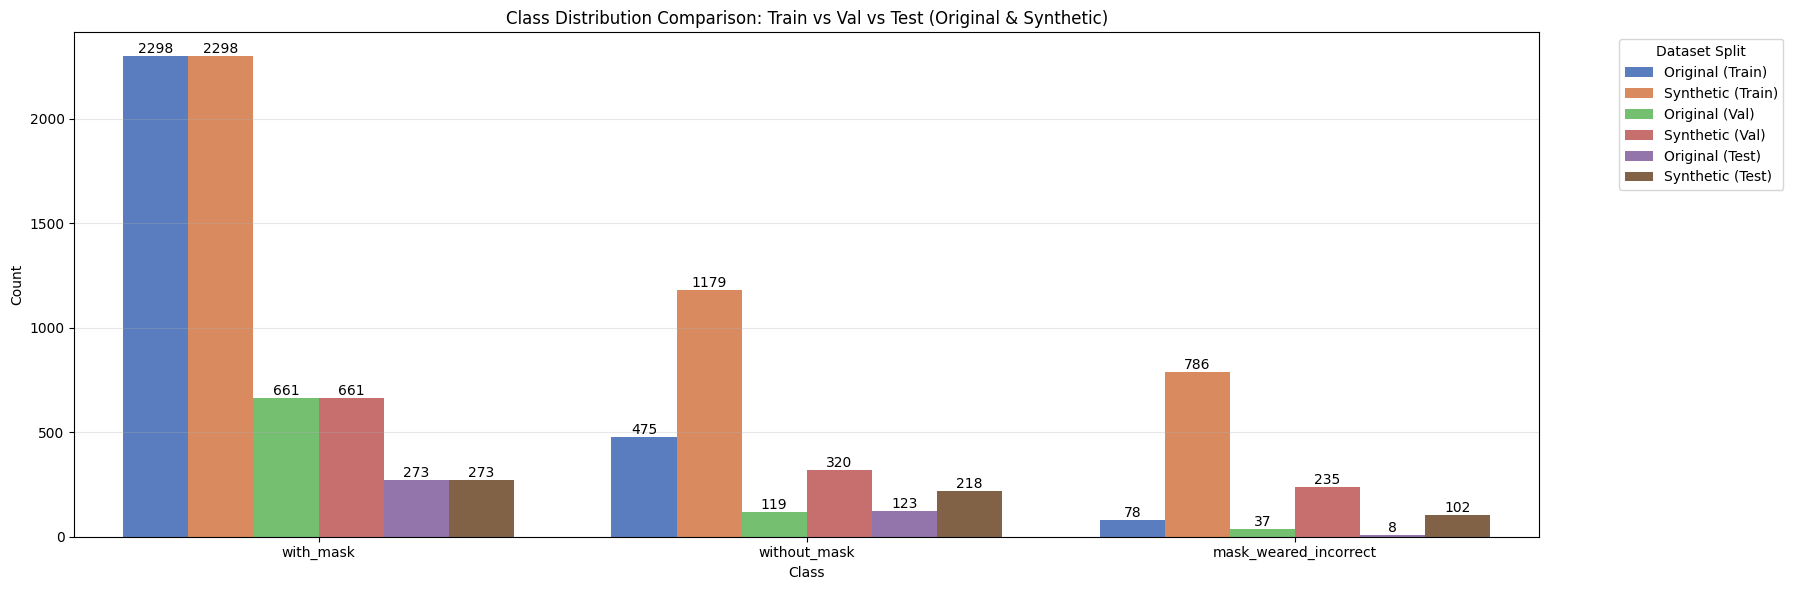

In [6]:
# SPLIT: Stratified 70/20/10 based on Objects
# This also prepares the YOLO dataset structure directly.

yolo_root = os.path.abspath(os.path.join("../data", "yolo_dataset"))
if os.path.exists(yolo_root):
    shutil.rmtree(yolo_root)

if synthetic_dataset:
    print(f"Performing Stratified Split & YOLO Prep on {len(synthetic_dataset)} images...")
    
    # dataset is usually the original dataset object used for structure, but here we pass synthetic_dataset
    # because that's what we want to split. 
    # However, stratified_yolo_split expects a dataset object that has .xmls and .imgs attributes.
    # synthetic_dataset is a FaceMaskDataset instance, so it should work.
    
    train_indices, val_indices, test_indices = stratified_yolo_split(
        synthetic_dataset, 
        output_root=yolo_root, 
        split_ratios=(0.7, 0.2, 0.1)
    )
    
    print(f"Stratified Split Result -> Train: {len(train_indices)}, Val: {len(val_indices)}, Test: {len(test_indices)}")
    
    # Update Subsets for PyTorch usage if needed (though we use YOLO mainly)
    dataset_train = torch.utils.data.Subset(synthetic_dataset, train_indices)
    dataset_val = torch.utils.data.Subset(synthetic_dataset, val_indices)
    dataset_test = torch.utils.data.Subset(synthetic_dataset, test_indices)
    
    # Visualizing Class Distribution with new splits
    plot_class_distribution_comparison(dataset, train_indices, val_indices, test_indices, synthetic_dataset)
else:
    print("WARNING: No synthetic dataset found.")


Visualizing 3 random samples (Original vs Synthetic)...


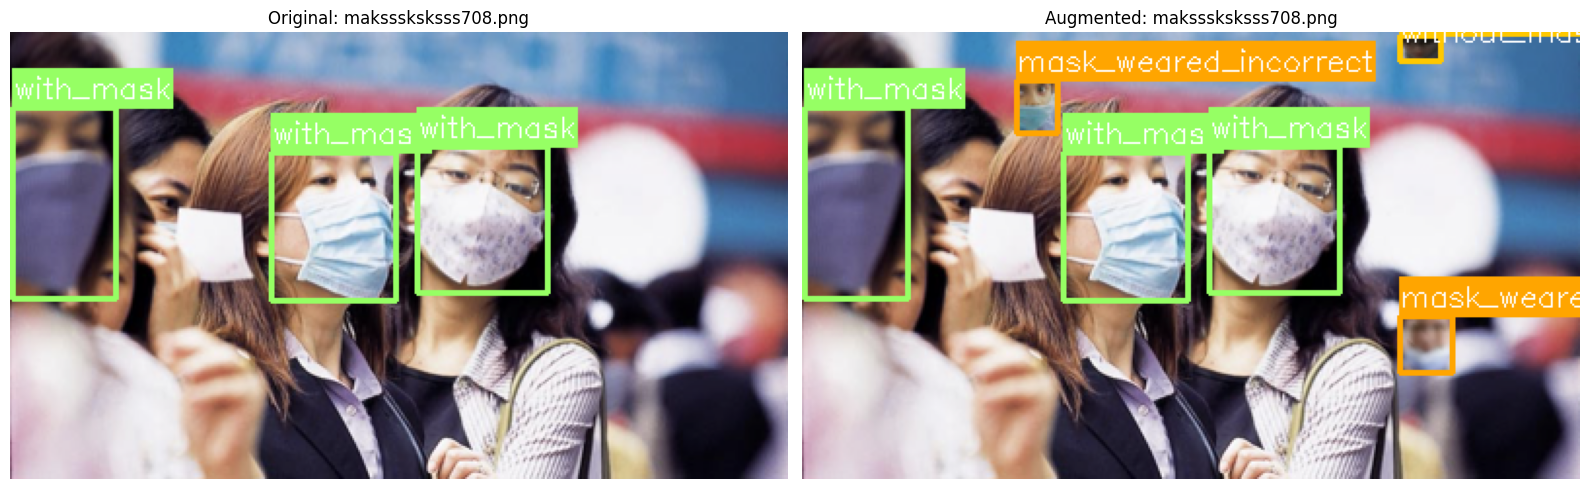

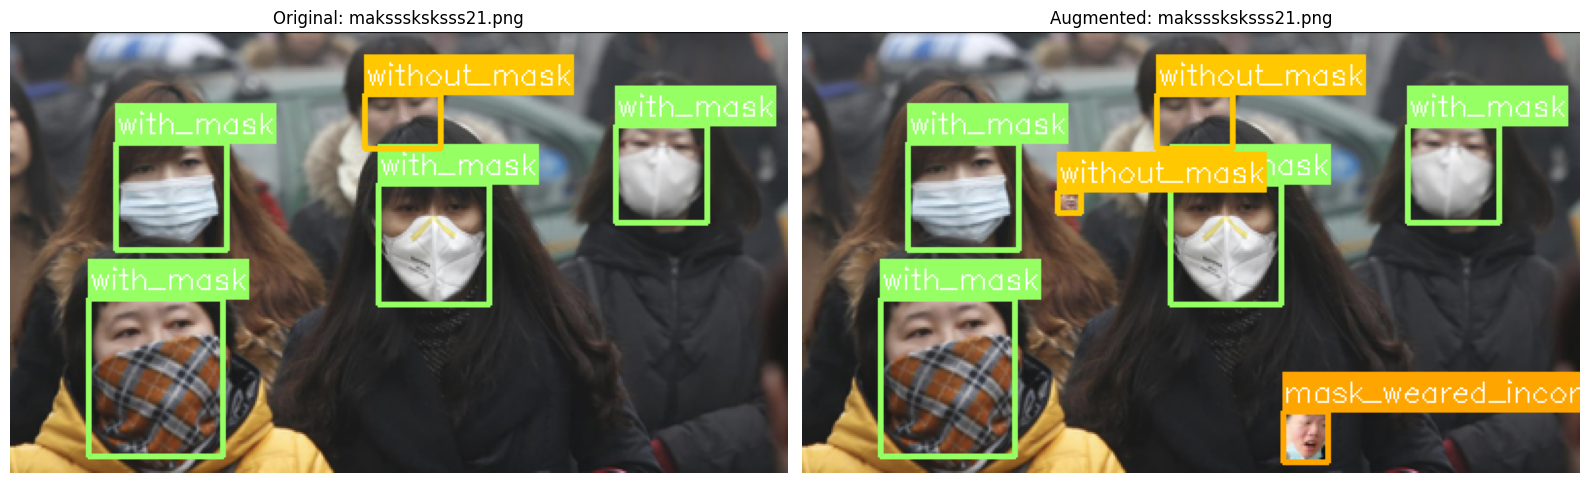

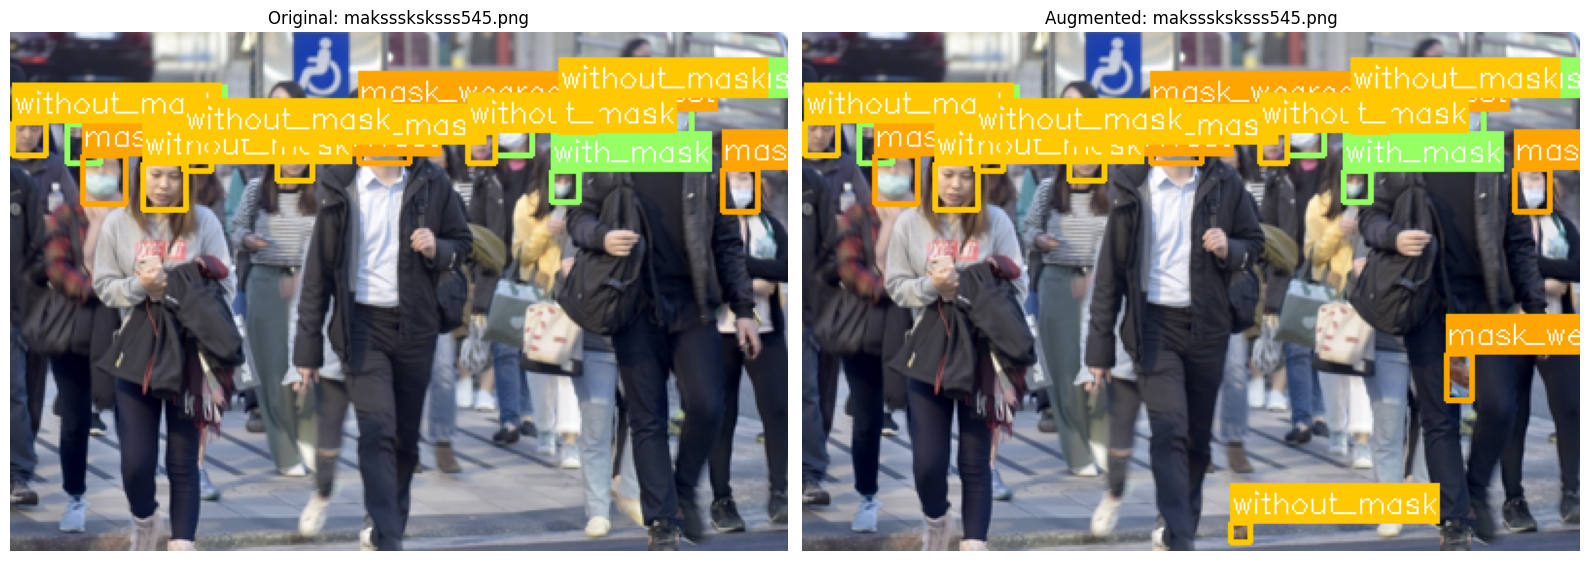

In [7]:
# --- VISUALIZATION: Original vs Synthetic Side-by-Side (With Bounding Boxes) ---

def visualize_comparison(original_dataset, synthetic_dataset, indices, num_samples=3):
    print(f"Visualizing {num_samples} random samples (Original vs Synthetic)...")
    
    # Class Config
    label_names = {1: "with_mask", 2: "without_mask", 3: "mask_weared_incorrect"}
    # RGB Colors for Matplotlib/OpenCV conversion handling
    # Green, Red, Orange
    label_colors = {1: (150, 255, 100), 2: (255, 200, 0), 3: (255, 165, 0)}
    
    # Selection
    if len(indices) < num_samples:
        selected_indices = indices
    else:
        selected_indices = random.sample(indices, num_samples)
    
    for idx in selected_indices:
        # Assuming datasets are aligned by index (sorted filenames)
        # Use original_dataset to get filenames
        img_name = original_dataset.imgs[idx]
        xml_name = original_dataset.xmls[idx] 
        
        # --- Helper to load and draw ---
        def load_and_draw(dataset, title_prefix):
            img_path = os.path.join(dataset.img_dir, img_name)
            xml_path = os.path.join(dataset.annot_dir, xml_name)
            
            # Load Image
            if not os.path.exists(img_path):
                return None, f"Missing Image: {img_path}"
                
            img = cv2.imread(img_path)
            if img is None:
                return None, "Failed to load image"
            
            # Convert to RGB for plotting
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            
            # Load Labels
            boxes = []
            labels = []
            if os.path.exists(xml_path):
                try:
                    tree = ET.parse(xml_path)
                    for obj in tree.findall("object"):
                        name = obj.find("name").text
                        # Map name to label ID
                        lbl_id = dataset.label_map.get(name, 0)
                        
                        bnd = obj.find("bndbox")
                        xmin = int(float(bnd.find("xmin").text))
                        ymin = int(float(bnd.find("ymin").text))
                        xmax = int(float(bnd.find("xmax").text))
                        ymax = int(float(bnd.find("ymax").text))
                        boxes.append([xmin, ymin, xmax, ymax])
                        labels.append(lbl_id)
                except Exception as e:
                    print(f"Error parsing XML {xml_path}: {e}")
            
            # Draw on Image (using cv2 drawing functions)
            for box, lbl in zip(boxes, labels):
                c = label_colors.get(lbl, (255, 255, 255))
                txt = label_names.get(lbl, "Unknown")
                x1, y1, x2, y2 = box
                
                # Draw Box
                cv2.rectangle(img, (x1, y1), (x2, y2), c, 2)
                
                # Draw Text Label with Background
                (w, h), _ = cv2.getTextSize(txt, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 1)
                # Ensure background is within bounds
                cv2.rectangle(img, (x1, max(0, y1-20)), (x1+w, y1), c, -1) 
                cv2.putText(img, txt, (x1, max(5, y1-5)), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,255,255), 1)
                
            return img, None

        # Process Original
        orig_img, err1 = load_and_draw(original_dataset, "Original")
        
        # Process Synthetic
        synth_img, err2 = load_and_draw(synthetic_dataset, "Augmented")
        
        if orig_img is None or synth_img is None:
            print(f"Skipping {img_name}: {err1 or err2}")
            continue
            
        # Plot Side-by-Side
        fig, axes = plt.subplots(1, 2, figsize=(16, 8))
        axes[0].imshow(orig_img)
        axes[0].set_title(f"Original: {img_name}")
        axes[0].axis('off')
        
        axes[1].imshow(synth_img)
        axes[1].set_title(f"Augmented: {img_name}")
        axes[1].axis('off')
        
        plt.tight_layout()
        plt.show()

# Execute Visualization if data exists
if synthetic_dataset:
    # Visualize comparison using TRAINING indices (so we see what the model learns)
    visualize_comparison(dataset_train_full, synthetic_dataset, train_indices, num_samples=3)


## 2. Methodology: Training & Evaluation

In [8]:
# --- YOLO Training with MLflow (Default Ultralytics Integration) ---
import mlflow
import os
import sys
import torch
from ultralytics import YOLO, settings

# MLflow Configuration
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
mlruns_dir = os.path.join(project_root, "mlruns")
tracking_uri = f"file:///{mlruns_dir}"
model_name = "yolo26s"

mlflow.set_tracking_uri(tracking_uri)

# Configure MLflow via Environment Variables (Ultralytics reads these)
os.environ["MLFLOW_TRACKING_URI"] = tracking_uri
os.environ["MLFLOW_EXPERIMENT_NAME"] = f"Face_Mask_Detection_{model_name}"

# Enable Ultralytics MLflow integration
settings.update({"mlflow": True})

# Enable System Metrics (Optional)
try:
    mlflow.enable_system_metrics_logging()
except Exception:
    pass

print(f"MLflow Tracking URI: {tracking_uri}")
print(f"Experiment Name: {os.environ['MLFLOW_EXPERIMENT_NAME']}")

# Initialize Model
print(f"Loading model: {model_name}")
model = YOLO(model_name)

# Data Path
yolo_root = os.path.abspath(os.path.join("../data", "yolo_dataset"))
config_path = os.path.join(yolo_root, "data.yaml")

print("Starting YOLO Training...")
# Ultralytics will automatically log to MLflow if installed and settings['mlflow'] is True
results = model.train(
    data=config_path,
    epochs=50,
    imgsz=640,
    batch=8,
    workers=4,
    device=0 if torch.cuda.is_available() else 'cpu',
    exist_ok=True,
    verbose=True,
    name="yolo_run"
)

print("Training Complete.")

# Validation
print("Validating on val set...")
model.val(split='val')

print("Training and Validation and Logging Complete.")
sys.stdout.flush()


MLflow Tracking URI: file:///d:\_pribadi\verihubs\face_mask_detections\mlruns
Experiment Name: Face_Mask_Detection_yolo26s
Loading model: yolo26s
Starting YOLO Training...
New https://pypi.org/project/ultralytics/8.4.13 available  Update with 'pip install -U ultralytics'
Ultralytics 8.4.12  Python-3.10.11 torch-2.10.0+cu126 CUDA:0 (NVIDIA GeForce RTX 4070 Laptop GPU, 8188MiB)
engine\trainer: agnostic_nms=False, amp=True, angle=1.0, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=d:\_pribadi\verihubs\face_mask_detections\data\yolo_dataset\data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, end2end=None, epochs=50, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_

d:\_pribadi\verihubs\face_mask_detections\.venv\lib\site-packages\mlflow\tracking\_tracking_service\utils.py:178: FutureWarning: The filesystem tracking backend (e.g., './mlruns') will be deprecated in February 2026. Consider transitioning to a database backend (e.g., 'sqlite:///mlflow.db') to take advantage of the latest MLflow features. See https://github.com/mlflow/mlflow/issues/18534 for more details and migration guidance. For migrating existing data, https://github.com/mlflow/mlflow-export-import can be used.
  return FileStore(store_uri, store_uri)
2026/02/09 16:17:59 INFO mlflow.tracking.fluent: Experiment with name 'Face_Mask_Detection_yolo26s' does not exist. Creating a new experiment.
2026/02/09 16:17:59 INFO mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics. Set logger level to DEBUG for more details.
2026/02/09 16:17:59 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.


MLflow: logging run_id(52a3c5d3b4fb488399a31b396336cb1e) to file:///d:\_pribadi\verihubs\face_mask_detections\mlruns
MLflow: disable with 'yolo settings mlflow=False'
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to D:\_pribadi\hadl_case_study\runs\detect\yolo_run
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       1/50      2.87G      1.421      3.205   0.004884          4        640: 100% ━━━━━━━━━━━━ 76/76 3.0it/s 25.6s0.2ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 11/11 1.2s/it 13.0s0.3s
                   all        169       1216      0.657      0.661      0.654      0.467

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       2/50      3.06G      1.216      1.295   0.004209         14        640: 100% ━━━━━━━━━━━━ 76/76 7.0it/s 10.8s0.1s
                 Class     Images  Instances      

2026/02/09 16:28:49 INFO mlflow.system_metrics.system_metrics_monitor: Stopping system metrics monitoring...
2026/02/09 16:28:49 INFO mlflow.system_metrics.system_metrics_monitor: Successfully terminated system metrics monitoring!


MLflow: results logged to file:///d:\_pribadi\verihubs\face_mask_detections\mlruns
MLflow: disable with 'yolo settings mlflow=False'
Training Complete.
Validating on val set...
Ultralytics 8.4.12  Python-3.10.11 torch-2.10.0+cu126 CUDA:0 (NVIDIA GeForce RTX 4070 Laptop GPU, 8188MiB)
YOLO26s summary (fused): 122 layers, 9,466,341 parameters, 0 gradients, 20.5 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 1770.4365.9 MB/s, size: 181.6 KB)
val: Scanning D:\_pribadi\verihubs\face_mask_detections\data\yolo_dataset\labels\val.cache... 169 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 169/169  0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 11/11 5.2it/s 2.1s0.1s
                   all        169       1216      0.942      0.903      0.955      0.785
             with_mask        146        661      0.937      0.893      0.943      0.658
          without_mask        169        320      0.936      0.872      0.948